# Importing Packages

In [24]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import os
import cv2
from PIL import Image, ImageDraw, ImageFont
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import torch.functional as F
import glob
import random

# Model Hyperparameters

In [3]:
batch_size = 8
learning_rate = 0.0001
num_epochs = 50
image_height = 256
image_width = 256
num_classes = 2

# Set Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# U-net Model Class

In [5]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True),
            nn.Conv2d(out_channels, out_channels, 3, padding = 1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace = True)
        )
    
    def forward(self, x):
        return self.conv(x)
    


class Attention_block(nn.Module):
    def __init__(self,F_g,F_l,F_int):
        super(Attention_block,self).__init__()
        self.W_g = nn.Sequential(
            nn.Conv2d(F_g, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
            )
        
        self.W_x = nn.Sequential(
            nn.Conv2d(F_l, F_int, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(F_int)
        )

        self.psi = nn.Sequential(
            nn.Conv2d(F_int, 1, kernel_size=1,stride=1,padding=0,bias=True),
            nn.BatchNorm2d(1),
            nn.Sigmoid()
        )
        
        self.relu = nn.ReLU(inplace=True)
        


    def forward(self,g,x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1+x1)
        psi = self.psi(psi)

        return x*psi

class UNet(nn.Module):
    def __init__(self, in_channels = 3, out_channels = 1):
        super().__init__()

        #Encoding Layers
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.encoder3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.encoder4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(512, 1024)

        #Decoding Layers
        self.decoder1 = nn.ConvTranspose2d(1024, 512, kernel_size = 2, stride = 2)
        self.att1 = Attention_block(F_g = 512, F_l = 512, F_int = 256)
        self.conv1 = DoubleConv(1024, 512) 

        self.decoder2 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.att2 = Attention_block(F_g = 256, F_l = 256, F_int = 128)
        self.conv2 = DoubleConv(512, 256) 

        self.decoder3 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.att3 = Attention_block(F_g = 128, F_l = 128, F_int = 64)
        self.conv3 = DoubleConv(256, 128) 

        self.decoder4 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.conv4 = DoubleConv(128, 64) 
        
        self.final = nn.Conv2d(64, out_channels, kernel_size = 1)

    def forward(self, x):
        enc1 = self.encoder1(x)
        pool1 = self.pool1(enc1)

        enc2 = self.encoder2(pool1)
        pool2 = self.pool2(enc2)

        enc3 = self.encoder3(pool2)
        pool3 = self.pool3(enc3)

        enc4 = self.encoder4(pool3)
        pool4 = self.pool4(enc4)

        bottleneck = self.bottleneck(pool4)

        dec1 = self.decoder1(bottleneck)
        att_enc4 = self.att1(g = dec1, x = enc4)
        dec1 = torch.cat((att_enc4, dec1), dim=1) 
        dec1 = self.conv1(dec1)
        
        dec2 = self.decoder2(dec1)
        att_enc3 = self.att2(g = dec2, x = enc3)
        dec2 = torch.cat((att_enc3, dec2), dim=1)
        dec2 = self.conv2(dec2)
        
        dec3 = self.decoder3(dec2)
        att_enc2 = self.att3(g = dec3, x = enc2)
        dec3 = torch.cat((att_enc2, dec3), dim=1)
        dec3 = self.conv3(dec3)
        
        dec4 = self.decoder4(dec3)
        dec4 = torch.cat((enc1, dec4), dim=1)
        dec4 = self.conv4(dec4)
        
        out = self.final(dec4)

        return out

# Dataset Class and Transforms

In [6]:
class CrackSegmentationDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        all_files = os.listdir(data_dir)
        image_extensions = ('.jpg', '.jpeg', '.png')
        self.images = sorted([f for f in all_files if f.lower().endswith(image_extensions) and '_mask' not in f])

    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_name = self.images[index]
        img_path = os.path.join(self.data_dir, img_name)
        base_name = os.path.splitext(img_name)[0]
        mask_name = f"{base_name}_mask.png"
        mask_path = os.path.join(self.data_dir, mask_name)

        image = cv2.imread(img_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if image is None:
            raise ValueError(f"Could not load image: {img_path}")
        if mask is None:
            raise ValueError(f"Could not load mask: {mask_path}")
        
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.unsqueeze(0)
    

train_tf = A.Compose([
    A.Resize(image_height, image_width),
    A.Rotate(limit=35, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1),
    A.OneOf([
        A.GaussianBlur(blur_limit=(3, 7), p=0.5),
        A.MotionBlur(p=0.5),
    ], p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussNoise(p=0.2),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

val_tf = A.Compose([
    A.Resize(image_height, image_width),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Datasets and DataLoaders

In [7]:
train_dataset= CrackSegmentationDataset('./data/train', transform = train_tf)
val_dataset = CrackSegmentationDataset('./data/valid', transform = val_tf)
test_dataset = CrackSegmentationDataset('./data/test', transform = val_tf)

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True, num_workers = 0, pin_memory = False)
val_loader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, pin_memory = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False, num_workers = 0, pin_memory = False)

# Loss Function

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = torch.sigmoid(preds)
        
        preds = preds.view(-1)
        targets = targets.view(-1)
        
        intersection = (preds * targets).sum()
        dice_union = preds.sum() + targets.sum()
        
        dice = (2. * intersection + self.smooth) / (dice_union + self.smooth)
        
        return 1 - dice

def dice_coefficient_binary(preds, targets, smooth=1e-6):
    with torch.no_grad():
        preds = torch.sigmoid(preds)
        preds = (preds > 0.5).float() 
        targets = targets.float()
        
        intersection = (preds * targets).sum()
        dice_union = preds.sum() + targets.sum()
        
        dice = (2. * intersection + smooth) / (dice_union + smooth)
    return dice.item()

bce_criterion = nn.BCEWithLogitsLoss()
dice_criterion = DiceLoss()

def combined_loss(preds, targets):
    alpha = 0.5
    return alpha * bce_criterion(preds, targets) + (1 - alpha) * dice_criterion(preds, targets)

# Training and Validation Loops

In [ ]:
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='max',           
    patience=5      
)


#Training Loop
best_dice = -1.0
os.makedirs("checkpoints", exist_ok=True)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in tqdm(train_loader, desc = f"Epoch {epoch + 1}/{num_epochs}"):
        images, masks = images.to(device), masks.to(device).float()

        optimizer.zero_grad()

        preds = model(images)

        loss = combined_loss(preds, masks)

        loss.backward()

        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)

    # Validation Loop
    model.eval()

    val_dice_score = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device).float()
            preds = model(images)
            val_dice_score += dice_coefficient_binary(preds, masks)
        
    val_dice_score /= len(val_loader)
    scheduler.step(val_dice_score)

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Dice: {val_dice_score:.4f}")
        
    if val_dice_score > best_dice:
        best_dice = val_dice_score
        torch.save(model.state_dict(), "checkpoints/best_model_binary.pth")
        print(f"==> Saved new best model with Dice Score: {best_dice:.4f}")

# Visualizing Predictions

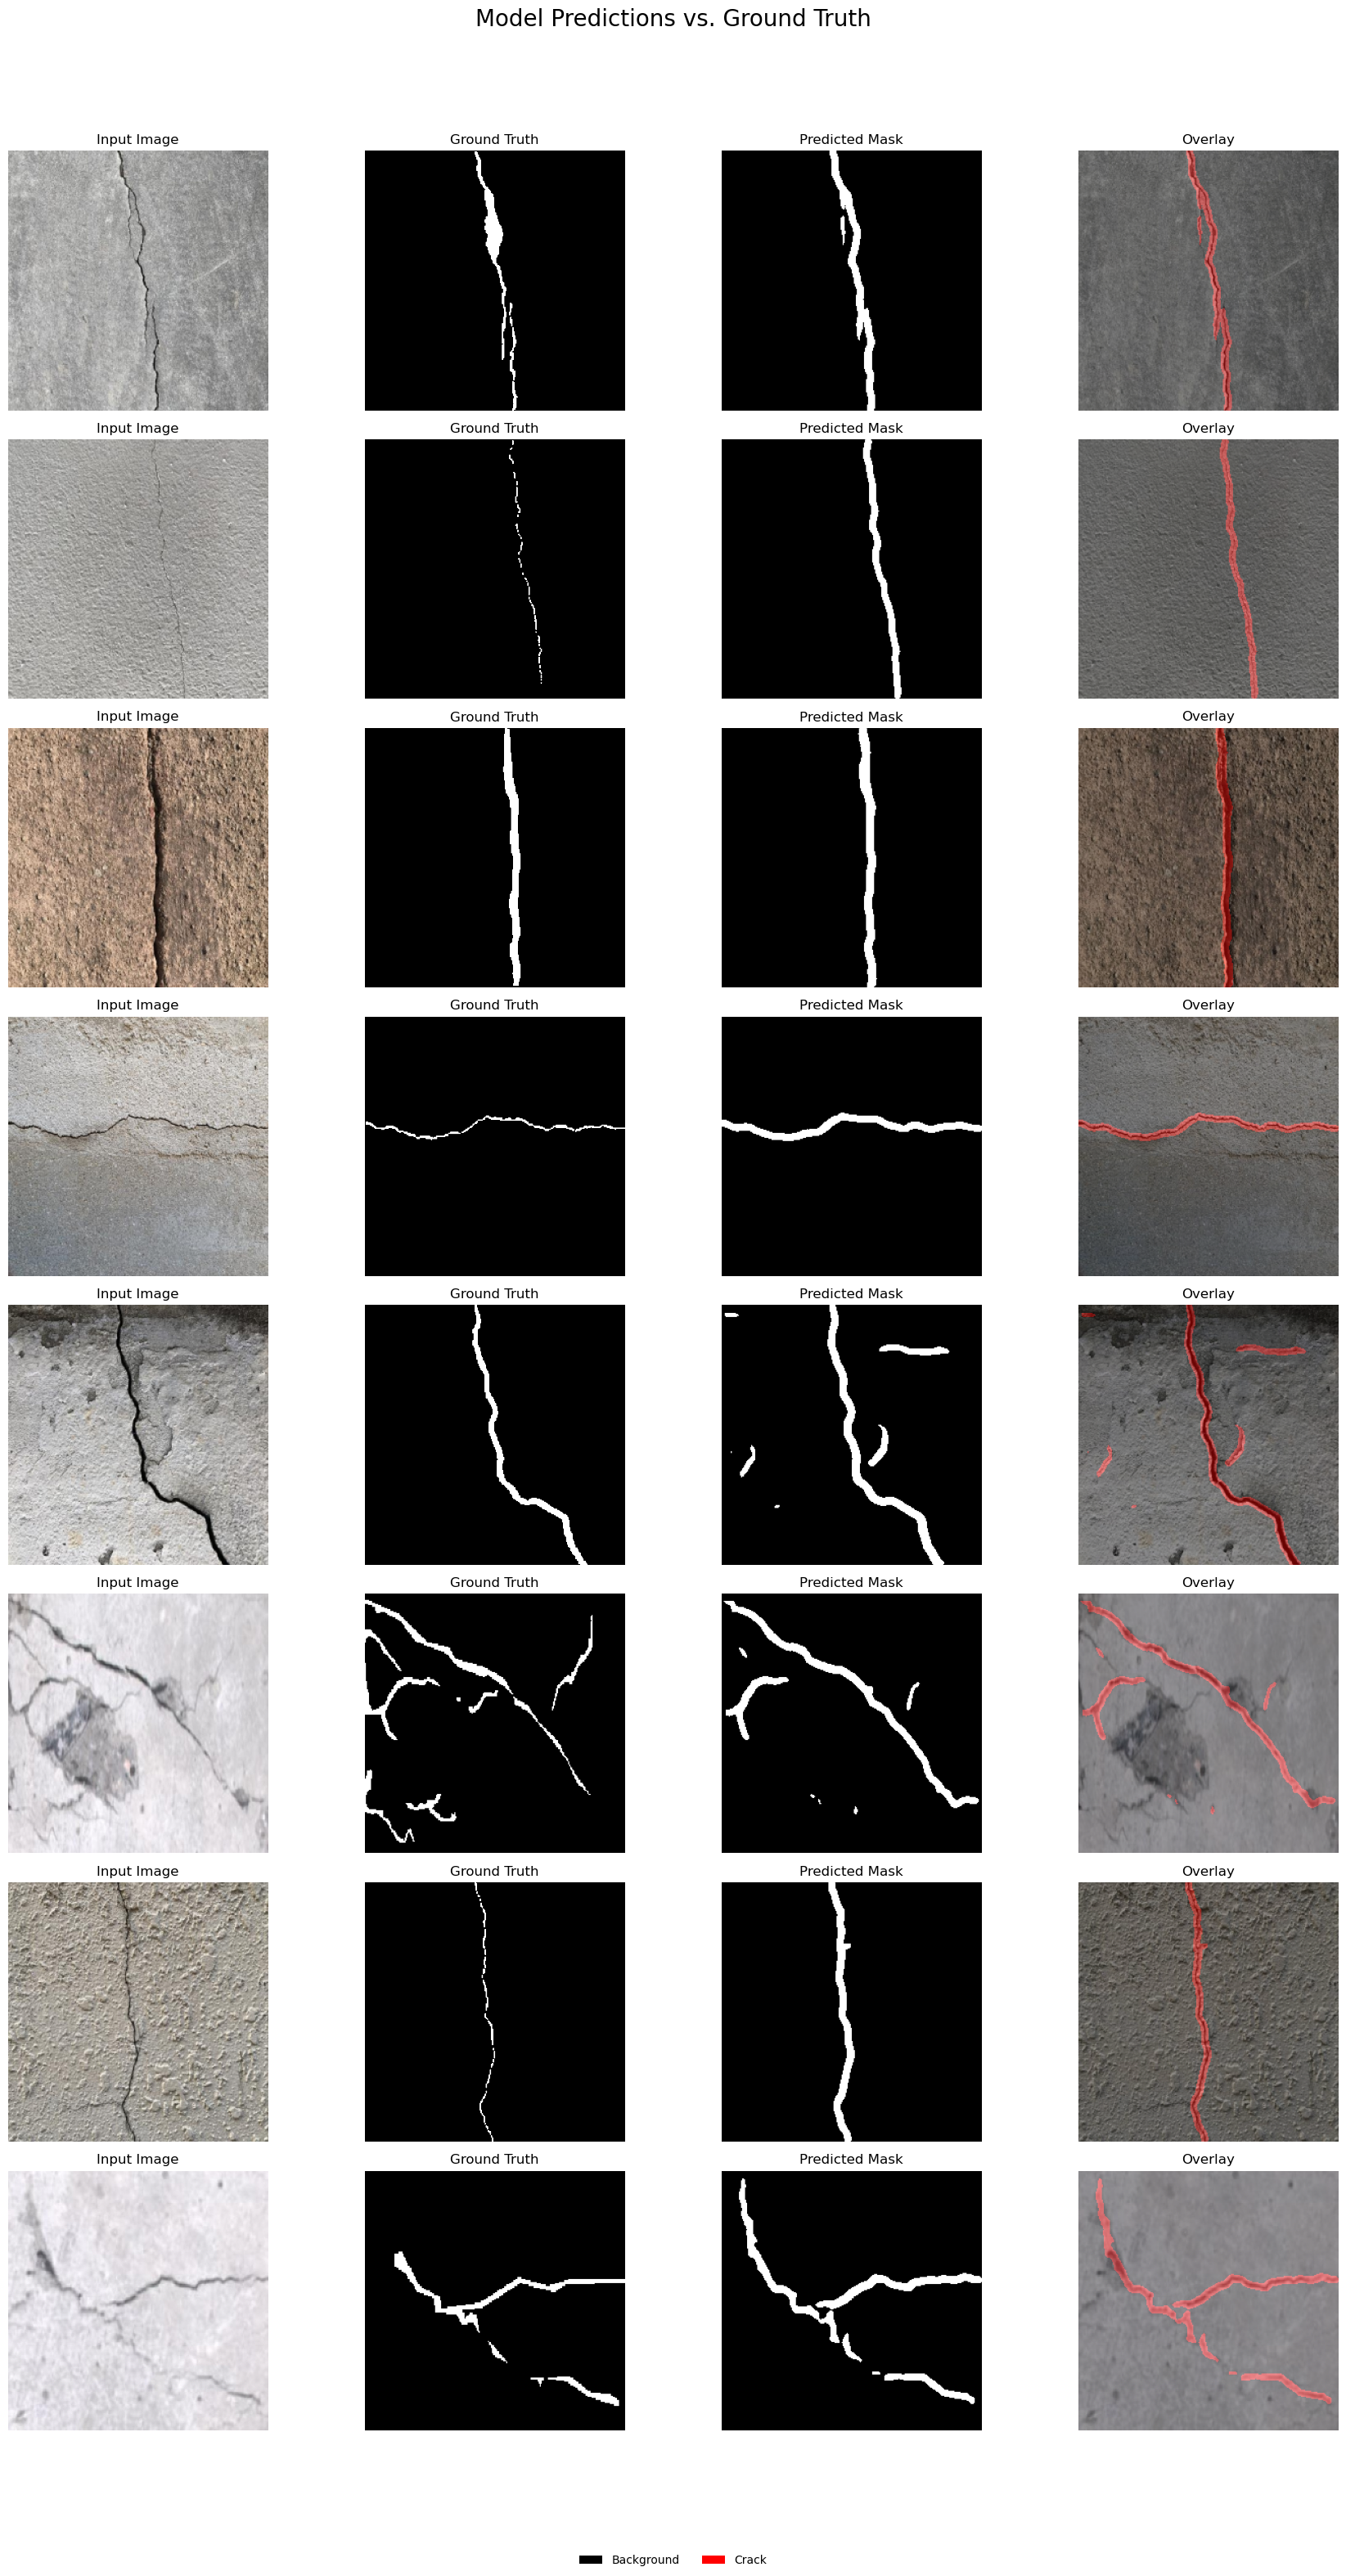

Saved visualization as 'predictions_visualization_binary.png'


In [25]:
class_labels = ["Background", "Crack"]
class_colors = [[0, 0, 0], [255, 0, 0]]
cmap = ListedColormap(np.array(class_colors[1:])/255.0)
num_classes = len(class_labels)

model.load_state_dict(torch.load('checkpoints/best_model_binary.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    num_batches = len(test_loader)

    random_batch_index = random.randint(0, num_batches - 1)

    
    for i, (batch_imgs, batch_masks) in enumerate(test_loader):
        if i == random_batch_index:
            imgs, masks = batch_imgs, batch_masks
            
    imgs, masks = imgs.to(device), masks.to(device)

    preds_logits = model(imgs)

    preds = torch.sigmoid(preds_logits)
    preds = (preds > 0.5).float()

    fig, axes = plt.subplots(batch_size, 4, figsize=(18, batch_size * 4))
    fig.suptitle("Model Predictions vs. Ground Truth", fontsize=20)

    for i in range(batch_size):
        img_np = imgs[i].cpu().permute(1, 2, 0).numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        img_np = std * img_np + mean
        img_np = np.clip(img_np, 0, 1)

        # 1. Input Image
        axes[i, 0].imshow(img_np)
        axes[i, 0].set_title("Input Image")

        # 2. Ground Truth
        axes[i, 1].imshow(masks[i].squeeze(0).cpu(), cmap='gray', vmin=0, vmax=1)
        axes[i, 1].set_title("Ground Truth")

        # 3. Predicted Mask
        axes[i, 2].imshow(preds[i].squeeze(0).cpu(), cmap='gray', vmin=0, vmax=1)
        axes[i, 2].set_title("Predicted Mask")

        # 4. Overlay
        pred_mask_rgb = np.zeros_like(img_np)
        pred_mask_squeezed = preds[i].squeeze(0).cpu().numpy()
        pred_mask_rgb[pred_mask_squeezed == 1] = [1, 0, 0]

        img_uint8 = (img_np * 255).astype(np.uint8)
        mask_uint8 = (pred_mask_rgb * 255).astype(np.uint8)

        overlay = cv2.addWeighted(img_uint8, 0.6, mask_uint8, 0.4, 0)
        axes[i, 3].imshow(overlay)
        axes[i, 3].set_title("Overlay")

    for ax in axes.flat:
        ax.axis("off")
        
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])
    legend_elements = [Patch(facecolor=np.array(c)/255.0, label=l) for c, l in zip(class_colors, class_labels)]
    fig.legend(handles=legend_elements, loc="lower center", ncol=len(class_labels), frameon=False)
    plt.savefig("predictions_visualization_binary.png", dpi=300, bbox_inches="tight")
    plt.show()
    
    print("Saved visualization as 'predictions_visualization_binary.png'")

# Model Performance on Test Set

In [ ]:
model.eval()
test_loss = 0.0
total_test_dice = 0.0

with torch.no_grad():
    for imgs, masks in tqdm(test_loader, desc="Testing..."):
        imgs, masks = imgs.to(device), masks.to(device).float()
        
        preds = model(imgs)

        loss = combined_loss(preds, masks)
        test_loss += loss.item()
        
        dice_score = dice_coefficient_binary(preds, masks)
        total_test_dice += dice_score

avg_test_loss = test_loss / len(test_loader)
avg_test_dice = total_test_dice / len(test_loader)

print(f"\nTest Set Performance:")
print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Dice Score: {avg_test_dice:.4f}")

In [10]:
BEST_MODEL_PATH = "checkpoints/best_model_binary.pth"
GIF_OUTPUT_PATH = "results_demo.gif"
NUM_GIF_FRAMES = 10 # Number of test images to include in the GIF

import imageio
import os

class_labels = ["Background", "Crack"]
class_colors = [[0, 0, 0], [255, 0, 0]]
cmap = ListedColormap(np.array(class_colors[1:])/255.0)
num_classes = len(class_labels)

model.load_state_dict(torch.load('checkpoints/best_model_binary.pth'))
model.to(device)
model.eval()

with torch.no_grad():
    for i, (imgs, masks) in enumerate(test_loader):
        if i >= NUM_GIF_FRAMES:
            break
        
        imgs, masks = imgs.to(device), masks.to(device)

        preds_logits = model(imgs)
        preds = torch.sigmoid(preds_logits)
        preds = (preds > 0.5).float()

        for j in range(imgs.size(0)):
            img_np = imgs[j].cpu().permute(1, 2, 0).numpy()
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            img_np = std * img_np + mean
            img_np = np.clip(img_np, 0, 1)

            pred_mask_rgb = np.zeros_like(img_np)
            pred_mask_squeezed = preds[j].squeeze(0).cpu().numpy()
            pred_mask_rgb[pred_mask_squeezed == 1] = [1, 0, 0]

            img_uint8 = (img_np * 255).astype(np.uint8)
            mask_uint8 = (pred_mask_rgb * 255).astype(np.uint8)

            overlay = cv2.addWeighted(img_uint8, 0.6, mask_uint8, 0.4, 0)

            # Save each frame as an image
            output_path = f"temp_frame_{i * imgs.size(0) + j}.png"
            cv2.imwrite(output_path, overlay)

In [ ]:
frames_folder = 'GIF Frames'
filenames = sorted(os.listdir(frames_folder))
with imageio.get_writer('model_predictions.gif', mode='I', duration=0.5) as writer:
    for filename in os.listdir(frames_folder):
        image_path = os.path.join(frames_folder, filename)
        image = imageio.imread(image_path)
        writer.append_data(image)

print("GIF saved as 'model_predictions.gif'")

C:\Users\kissi\AppData\Local\Temp\ipykernel_11688\1038270299.py:7: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(image_path)


GIF saved as 'model_predictions.gif'
